## Demand Forecasting Using Time Series

Objective:
Forecast monthly demand and compare SARIMA, Prophet, and rolling forecasts.

Business Context:
Used for inventory planning and supply chain decision-making.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv(r"C:\Users\shrid\Desktop\Data science\Time series\monthly_demand_forecasting_data - Times series.csv")
df.head()

,Date,Sales
0,2018-01-01,235
1,2018-02-01,244
2,2018-03-01,270
3,2018-04-01,285
4,2018-05-01,235


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    84 non-null     object
 1   Sales   84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
df.describe()

,Sales
count,84.000000
mean,347.869048
std,93.195581
min,170.000000
25%,267.500000
50%,343.000000
75%,423.000000
max,538.000000


In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_index("Date").sort_index()

In [8]:
df.head()

,Sales
Date,
2018-01-01,235
2018-02-01,244
2018-03-01,270
2018-04-01,285
2018-05-01,235


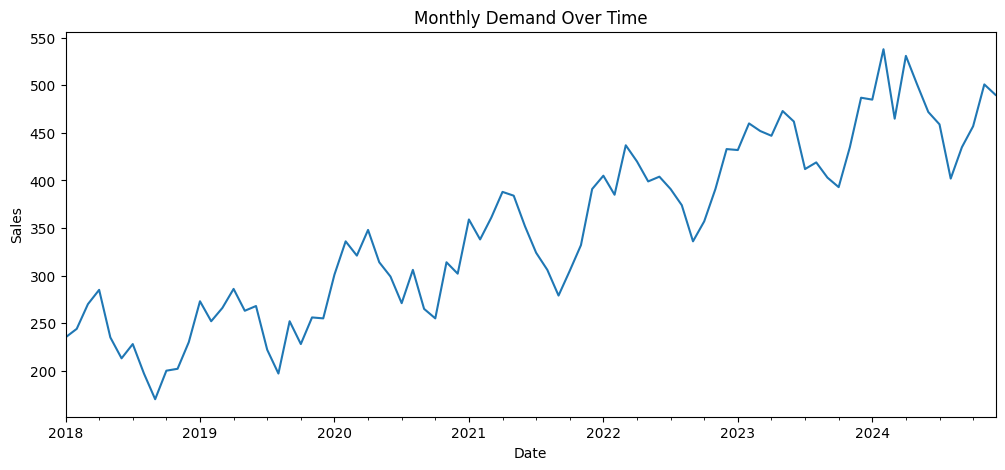

In [9]:
df['Sales'].plot(figsize=(12,5))
plt.title("Monthly Demand Over Time")
plt.ylabel("Sales")
plt.show()

# The time series shows an upward trend with clear annual seasonality, indicating suitability for seasonal models.

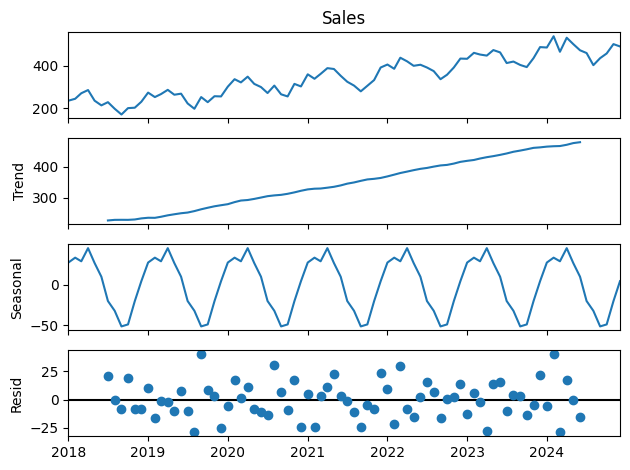

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Sales'], model='additive')
decomposition.plot()
plt.show()

# Decomposition confirmed strong annual seasonality and a positive long-term trend.

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Sales'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])


ADF Statistic: 0.40990309063804264
p-value: 0.9818615274019632


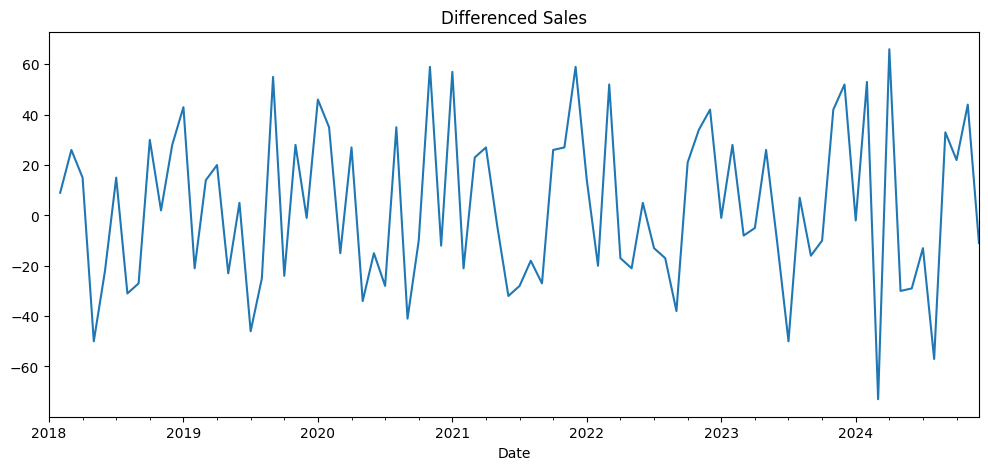

In [12]:
df['Sales_diff'] = df['Sales'].diff().dropna()

df['Sales_diff'].plot(figsize=(12,5))
plt.title("Differenced Sales")
plt.show()


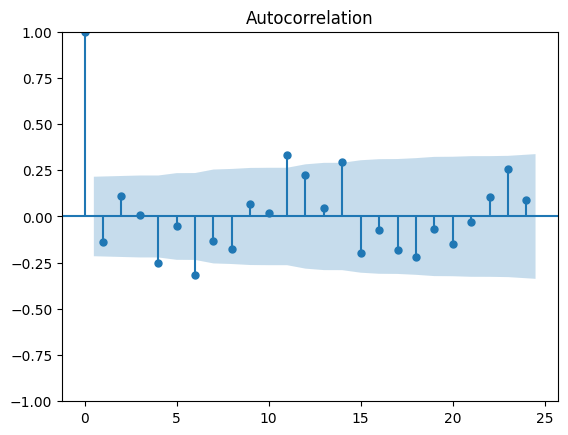

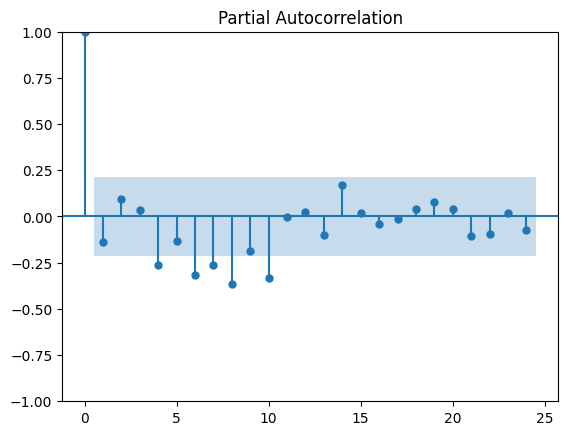

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Sales_diff'].dropna(), lags=24)
plot_pacf(df['Sales_diff'].dropna(), lags=24)
plt.show()


In [14]:
train = df[:-12]
test = df[-12:]


In [15]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_model = SARIMAX(
    train['Sales'],
    order=(1,1,1),              # AR, I, MA
    seasonal_order=(1,1,1,12)   # Seasonal AR, I, MA, period
)

sarima_result = sarima_model.fit(disp=False)


C:\Users\shrid\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\shrid\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
sarima_forecast = sarima_result.forecast(steps=12)

In [21]:
from prophet import Prophet
prophet_train = train[['Sales']].reset_index()  # Keeps ONLY Date + Sales
prophet_train.columns = ['ds', 'y']
prophet_model = Prophet()
prophet_model.fit(prophet_train)


13:00:41 - cmdstanpy - INFO - Chain [1] start processing
13:00:42 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = prophet_model.make_future_dataframe(periods=12, freq='MS')
prophet_forecast = prophet_model.predict(future)

prophet_pred = prophet_forecast[['ds', 'yhat']].set_index('ds').iloc[-12:]

In [24]:
history = list(train['Sales'])
rolling_preds = []

for t in range(len(test)):
    model = SARIMAX(history, order=(1,1,1), seasonal_order=(1,1,1,12))
    result = model.fit(disp=False)
    yhat = result.forecast()[0]
    rolling_preds.append(yhat)
    history.append(test['Sales'].iloc[t])


In [25]:
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# SARIMA
sarima_mape = mean_absolute_percentage_error(test['Sales'], sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test['Sales'], sarima_forecast))

# Prophet
prophet_mape = mean_absolute_percentage_error(test['Sales'], prophet_pred['yhat'])
prophet_rmse = np.sqrt(mean_squared_error(test['Sales'], prophet_pred['yhat']))

# Rolling SARIMA
rolling_mape = mean_absolute_percentage_error(test['Sales'], rolling_preds)
rolling_rmse = np.sqrt(mean_squared_error(test['Sales'], rolling_preds))


In [27]:
results = pd.DataFrame({
    "Model": ["SARIMA", "Prophet", "Rolling SARIMA"],
    "MAPE": [sarima_mape, prophet_mape, rolling_mape],
    "RMSE": [sarima_rmse, prophet_rmse, rolling_rmse]
})

results


,Model,MAPE,RMSE
0,SARIMA,0.050971,30.115519
1,Prophet,0.040966,28.925715
2,Rolling SARIMA,0.049498,29.108331


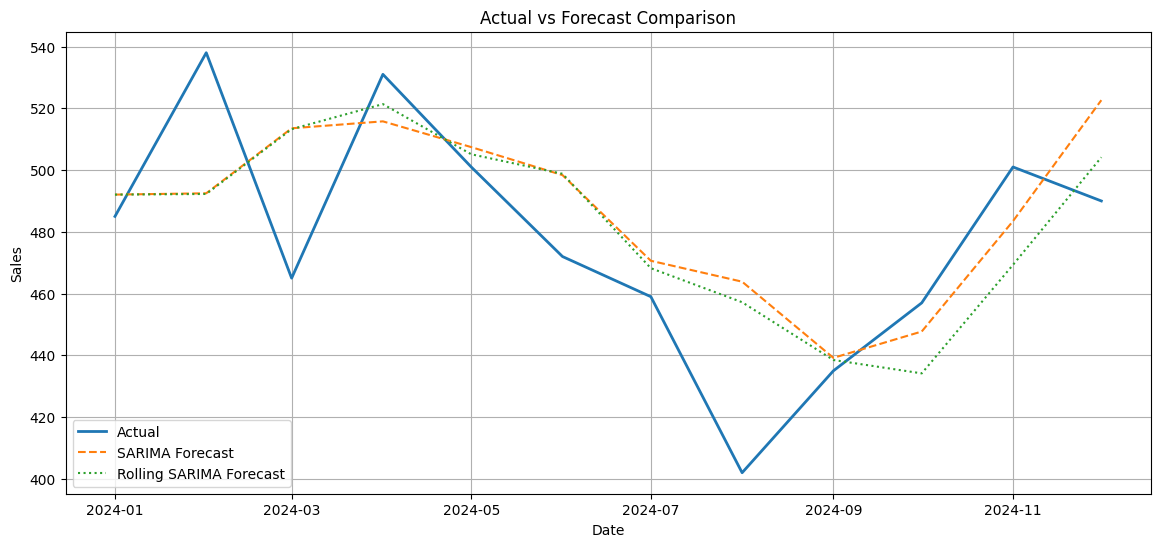

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

plt.plot(test.index, test["Sales"], label="Actual", linewidth=2)
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", linestyle="--")
plt.plot(test.index, rolling_preds, label="Rolling SARIMA Forecast", linestyle=":")

plt.title("Actual vs Forecast Comparison")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.show()

# I compared actual demand against SARIMA, Prophet, and rolling forecasts. Rolling SARIMA followed actual demand more closely due to continuous retraining, while Prophet provided smoother, more interpretable forecasts.